# Performance Evaluation of Terapixel Rendering in Cloud (Super) Computing

Terapixel images are the images composed of 1 trillion pixels and they can be used to present information to stakeholders intuitively, however, it requires a lot of compute power. So, it is advantageous to analyze the data collected from cloud super computing infrastructure to optimize the process and reduce the cost incurred.
  

## Business Understanding
- Which event types are taking most of the execution time?
> By analyzing dominant events we can manage resources efficiently and hence reduce the cost of operation.
- How GPU temperature and Performance are related?
> This will allow us to switch resource efficiently, "GPU throttling" mainly happens because of inefficient heat management. So, if we observe some GPUs starting to throttle because of increase in temperature we can switch them with GPUs of same throughput but at operating at lower temperatures. 
- Is there any impact of increased power draw on render time?
> With this we can quantify whether the increase in power draw has any impact on render time. If yes, then how much improvement are we getting? if no, what can be done to reduce the power consumption.
- Is there any performance difference in GPU cards?
> If different GPUs are performing at different throughputs we may well be able to allocate high end GPUs for more computation intensive tasks.
- Is there a specific pattern in which tiles/pixels are consuming more or less power?
> If we can figure out some specific regions on the terapixel image are taking more compute power, we can allocate flagship GPUs for those specific pixels and  mid to low end GPUs for rest of the pixels. This will improve the rendering of the image and also better resource management.

## Data Description
- **application-checkpoint.csv:** This file contains details of what type of events are happening at what timestamp and their hostname, taskId, jobId.
> - **timestamp:** The exact time at which the event started or stopped.
> - **hostname:** There are 1024 unique hostnames, each GPU can be considered as a host.
> - **eventName:** There are 5 events, Tiling, Render, Saving Config, Uploading, and TotalRender. 
> > - **TotalRender:** It is the complete task.
> > - **Render:** It is when tiles of the image is being rendered.
> > - **Tiling:** It the when the post-processing of rendered tile is done.
> > - **Saving Config:** Each task has some specific configurations, which is being saved.
> > - **Uploading:** Output of post-processed tiles are uploaded to Azure Blob Storage.
> - **eventType:** START or STOP, this shows whether the event is getting started or being terminated.
> - **jobId:** There are 3 jobIds for Azure batch job. For level 12, level 8, and level 4.
> - **taskId:** Id of the Azure batch task. Theres unique ID for each set of all 5 eventNames along with their start and stop timestamps. For example, if there are n rows in the application-checkpoint.csv there will be n/10 unique taskIds. 5 events and their start and stop rows = 5*2 = 10
- **gpu.csv:** This file consists of gpu conditions at a particular instance of time.
> - **gpuSerial:** There are 1024 GPUs and each have a unique serial number.
> - **gpuUUID:** The unique system id assigned by the Azure system to the GPU unit.
> - **powerDrawWatt:** Power drawn by the GPU in Watt.
> - **gpuTempC:** Temperature of the GPU in Celsius.
> - **gpuUtilPerc:** Percentage of cores of GPU utilized.
> - **gpuMemUtilPerc:** Percentage of memory of GPU utilized.
- **task-x-y.csv**: This file has x and y co-ordinates of the image tiles being rendered.
> - **x:** x co-ordinates of the image tiles.
> - **y:** y co-ordinates of the image tiles.
> - **level:** The visualization created is a zoomable "google maps style" map. In total we create 12 levels. Level 1 is zoomed right out and level 12 is zoomed right in. You will only see levels 4, 8 and 12 in the data as the intermediate level are derived in the tiling process.

## Data Processing
- Merging 3 raw data files into one.
> - First left join was performed on task-x-y.csv with application-checkpoint.csv on 'jobId' and 'taskId'.
> - Then inner join on merged data from previous step and gpu.csv using 'timestamp'.
- Calculation of time duration required by each event.
> - Extracted only time component from the timestamp column, as whole data was collected on the same date i.e., 2018-11-08.
> - Now grouped final merged data (from previous step) on eventName and eventType.
> - Made different dataframes for each event with their start and stop times separately. Hence, now we have 10 separate dataframes. 5x2=10; 5: events(*TotalRender, Render, Tiling, Saving Config, Uploading*), 2: eventType(*Start and Stop*)
> - Merged start and stop dataframes of respective events on taskId. Now we have 5 dataframes, 1 for each event.
> - Subtracted start time from stop time and stored it in separate column named "duration". 
> - Finally, stacked all the 5 event's dataframes into 1.

## Data Analysis

In [1]:
# Importing relevant packages...

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import IPython
from dateutil import parser
from datetime import datetime as dt, timedelta, date

In [2]:
# Loading raw as well as processed data...

app_check = pd.read_csv("../data/application-checkpoints.csv")
gpu = pd.read_csv("../data/gpu.csv")
task_xy = pd.read_csv("../data/task-x-y.csv")
merged_data = pd.read_csv("../data/merged_data.csv")
event_total_duration_df = pd.read_csv("../data/event-total-duration.csv")

In [4]:
print(f"Application Checkpoint has {app_check.shape[0]} rows and {app_check.shape[1]} columns")

Application Checkpoint has 660400 rows and 6 columns


In [63]:
app_check.head() # checking head of application checkpoint dataset...

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
1,2018-11-08T07:42:29.842Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
3,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
4,2018-11-08T07:43:13.957Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d


In [5]:
print(f"GPU has {gpu.shape[0]} rows and {gpu.shape[1]} columns") 

GPU has 1543681 rows and 8 columns


In [ ]:
gpu.head() # checking head of gpu dataset...

,timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,2018-11-08T08:27:10.314Z,8b6a0eebc87b4cb2b0539e81075191b900001C,323217055910,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,131.55,48,92,53
1,2018-11-08T08:27:10.192Z,d8241877cd994572b46c861e5d144c85000000,323617020295,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,117.03,40,92,48
2,2018-11-08T08:27:10.842Z,db871cd77a544e13bc791a64a0c8ed50000006,323217056562,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,121.64,45,91,44
3,2018-11-08T08:27:10.424Z,b9a1fa7ae2f74eb68f25f607980f97d7000010,325217085931,GPU-ad773c69-c386-a4be-b214-1ea4fc6045df,50.23,38,90,43
4,2018-11-08T08:27:10.937Z,db871cd77a544e13bc791a64a0c8ed50000003,323217056464,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,141.82,41,90,47


In [6]:
print(f"task-x-y has {task_xy.shape[0]} rows and {task_xy.shape[1]} columns")

task-x-y has 65793 rows and 5 columns


In [ ]:
task_xy.head() # checking head of task-x-y dataset...

,taskId,jobId,x,y,level
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12
1,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12
3,000993b6-fc88-489d-a4ca-0a44fd800bd3,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,235,11,12
4,000b158b-0ba3-4dca-bf5b-1b3bd5c28207,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,171,53,12


In [7]:
del merged_data['Unnamed: 0'] # deleting column "Unnamed: 0"...
print(f"Merged Data has {merged_data.shape[0]} rows and {merged_data.shape[1]} columns") 

Merged Data has 86633 rows and 16 columns


In [67]:
merged_data.head() # checking head of merged dataset...

,taskId,jobId,eventName,hostname,START,x,y,level,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,STOP,duration
0,00107991-1ad1-42c8-80b7-1c2dea75a1d5,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,Render,2ecb9d8d51bc457aac88073f6da05461000001,08:09:01.251000,241,166,12,323617042983,GPU-6139d74c-09ec-65da-328c-8d6e20da4247,107.92,49,95,60,08:09:48.150000,46.899
1,0010cbd2-8f82-4eb7-b374-f349c6616d27,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,Render,4a79b6d2616049edbf06c6aa58ab426a00000P,07:50:28.866000,114,152,12,325017018626,GPU-79b25d43-fec5-7caa-14d8-08b202d2bd2e,76.92,37,86,36,07:51:11.528000,42.662
2,0010cbd2-8f82-4eb7-b374-f349c6616d27,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,Render,4a79b6d2616049edbf06c6aa58ab426a00000P,07:50:28.866000,114,152,12,325117171263,GPU-90ba1ff7-6618-3c10-91f8-fb6e2363f4b8,48.52,39,0,0,07:51:11.528000,42.662
3,65d00e61-521b-4a3b-94e6-86a4c3965092,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,Render,8b6a0eebc87b4cb2b0539e81075191b900000O,08:26:28.850000,107,88,12,323617021030,GPU-712b411f-8a36-da2a-81f7-53a28c6de67d,40.01,38,0,0,08:27:13.182000,44.332
4,65d00e61-521b-4a3b-94e6-86a4c3965092,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,Render,a77ef58b13ad4c01b769dac8409af3f8000013,08:26:28.850000,107,88,12,323617021030,GPU-712b411f-8a36-da2a-81f7-53a28c6de67d,40.01,38,0,0,08:27:13.182000,44.332


In [3]:
# Calculating mean of gpu temperature, gpu utilization percentage, power draw, and duration 
# by grouping on gpu serial and eventName, excluding "TotalRender"...

avg_data = merged_data[merged_data['eventName'] != 'TotalRender'][['gpuSerial', 'eventName', 'gpuTempC', 'gpuUtilPerc', 'gpuMemUtilPerc', 'powerDrawWatt', 'duration']].groupby(['gpuSerial','eventName']).mean()
avg_data.index.names = ['gpuSerial', 'eventName']
avg_data.reset_index(inplace=True)

In [58]:
avg_data.head() # checking head of averaged dataset...

,gpuSerial,eventName,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,powerDrawWatt,duration
0,320118118607,Render,36.916667,88.583333,48.750000,105.404167,39.366583
1,320118118607,Saving Config,36.518519,70.185185,38.333333,84.607037,0.002704
2,320118118607,Tiling,36.440000,83.040000,44.880000,103.791600,0.937080
3,320118118607,Uploading,35.428571,31.785714,18.571429,62.997857,1.050143
4,320118118641,Render,39.375000,80.500000,44.312500,100.221250,42.524313


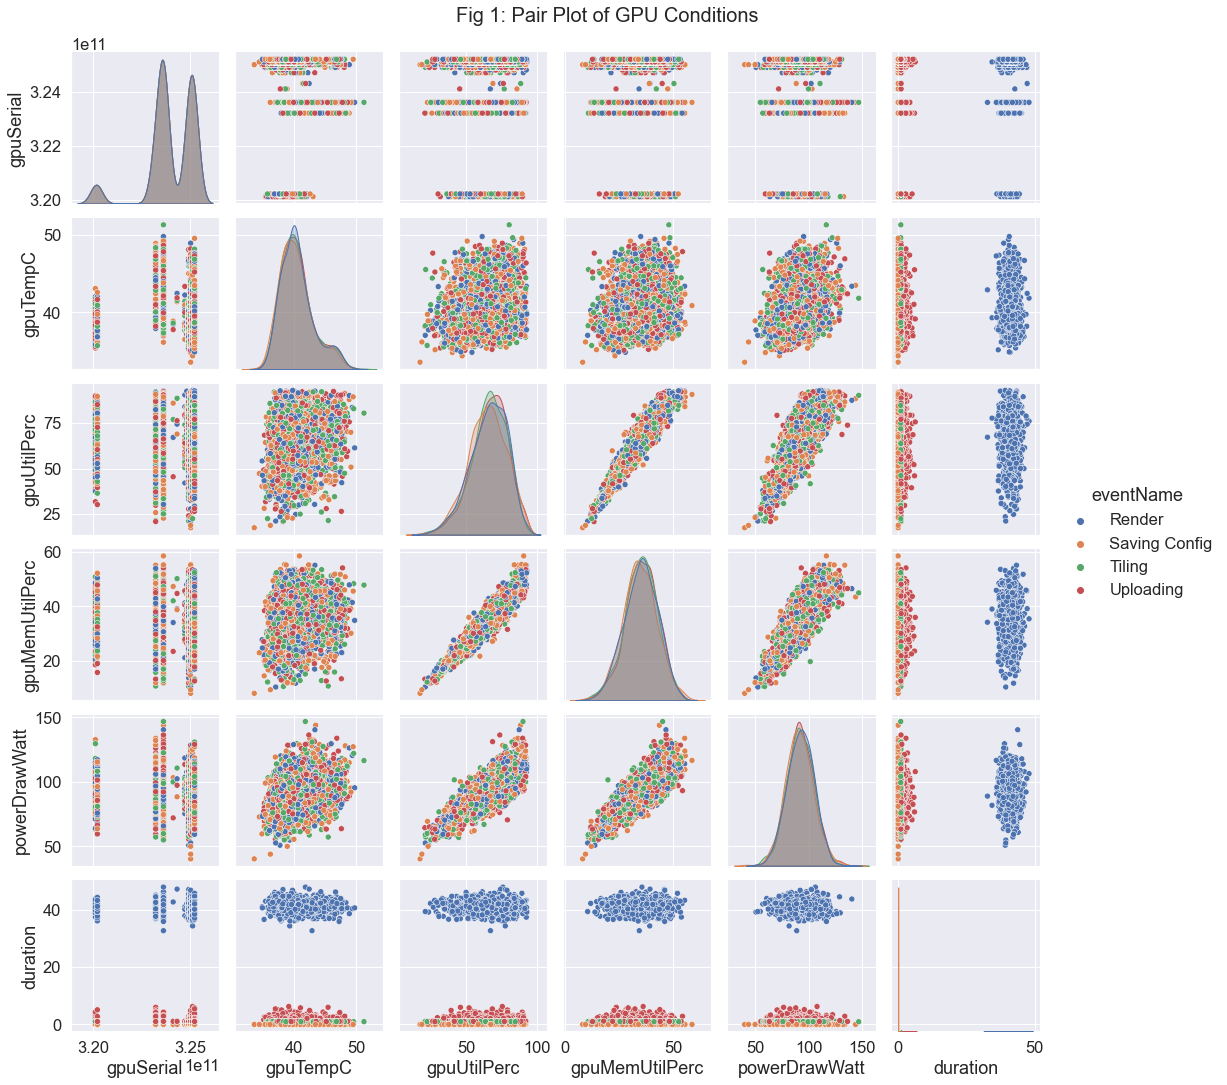

In [32]:
# Pairplot of averaged data to see relationship between various GPU conditions.
f = sns.pairplot(avg_data, hue="eventName") 
sns.set(font_scale = 2)
f.fig.suptitle("Fig 1: Pair Plot of GPU Conditions", fontsize = 20, y=1.01)
plt.show()

From Fig 1, we can get following insights:
- Duration of Render event is significantly more than other events.
- GPU temperature do not have any specific relation with Power draw, GPU memory utilization, GPU Utilization percentage.
- GPU Utilization percentage is very highly positively co-related to power draw and GPU memory utilization.
- GPU memory utilization has positive high co-relation with power drawn by the GPU.

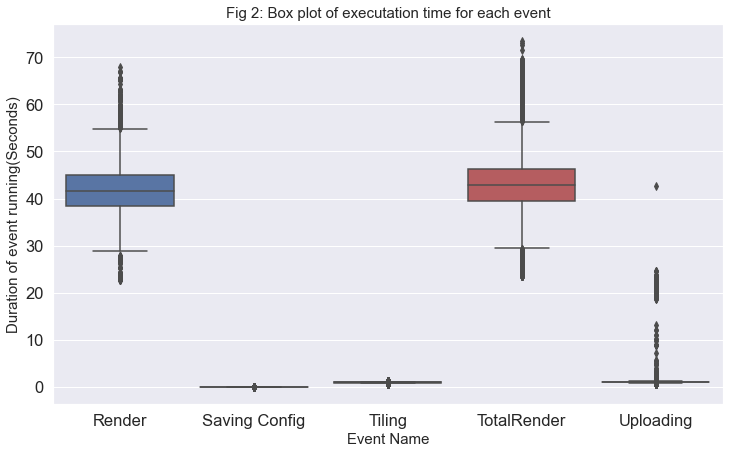

In [46]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(x="eventName", y="duration", data=merged_data)
sns.set(font_scale = 1.5)
plt.xlabel('Event Name', fontsize = 15)
plt.ylabel('Duration of event running(Seconds)', fontsize = 15)
plt.title("Fig 2: Box plot of executation time for each event", fontsize = 15)
plt.show()

In [62]:
del event_total_duration_df['Unnamed: 0']
event_total_duration_df.head()

,eventName,totalDuration
0,Tiling,17.986
1,Saving Config,0.046
2,Render,761.960
3,TotalRender,787.769
4,Uploading,25.755


From Fig 2 and table above, we can observe following key points:
- Event Render is taking most of the processing time as we can see it is almost equivalent to event TotalRender, however, we have considerable about of outliers in both Render and TotalRender.
- On an average Rendering takes 42 seconds and inter quantile range is from 38 to 45 approx. 
- Saving Config, Tiling, and Uploading doesn't take much computation time.
- Uploading event exhibits significant number of outliers.

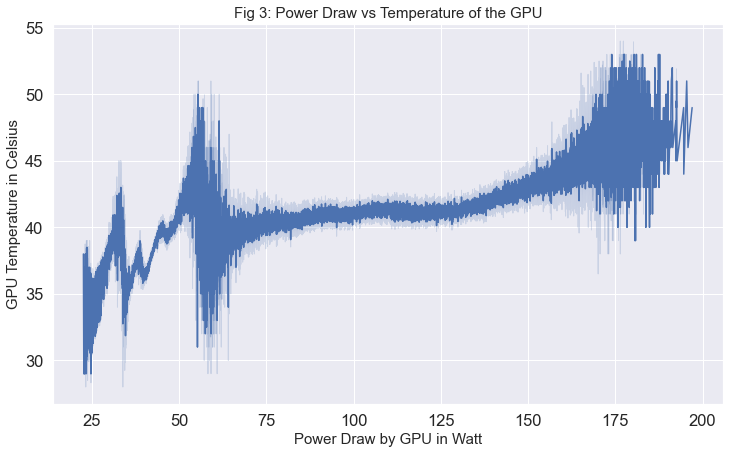

In [42]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.lineplot(data=gpu, x="powerDrawWatt", y="gpuTempC")
sns.set(font_scale = 1.5)
plt.xlabel('Power Draw by GPU in Watt', fontsize = 15)
plt.ylabel('GPU Temperature in Celsius', fontsize = 15)
plt.title("Fig 3: Power Draw vs Temperature of the GPU", fontsize = 15)
plt.show()

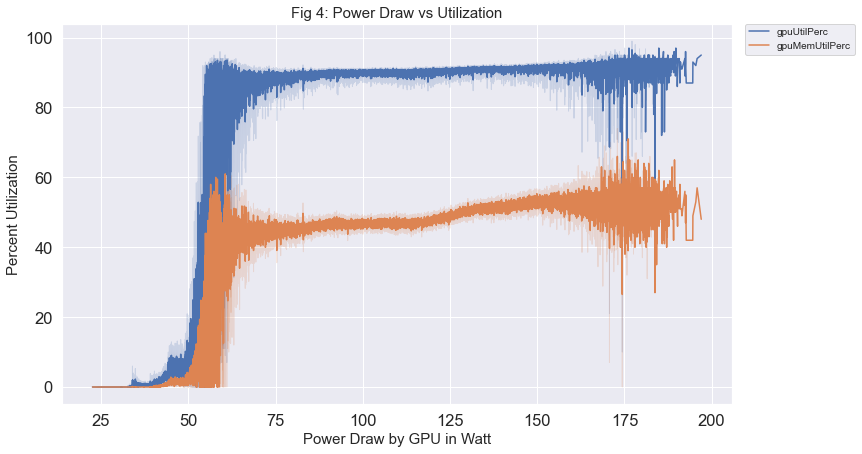

In [43]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.lineplot(data=pd.melt(gpu[["powerDrawWatt", "gpuUtilPerc", "gpuMemUtilPerc"]], 'powerDrawWatt'), x="powerDrawWatt", y="value", hue = "variable")
plt.xlabel('Power Draw by GPU in Watt', fontsize = 15)
plt.ylabel('Percent Utilization', fontsize = 15)
plt.title("Fig 4: Power Draw vs Utilization", fontsize = 15)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 10)
plt.show()

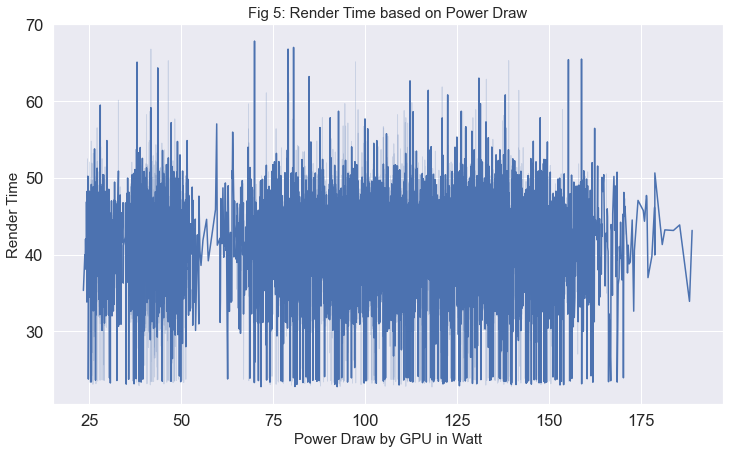

In [44]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.lineplot(data=merged_data.query("eventName == 'Render'"), x="powerDrawWatt", y="duration")
plt.xlabel('Power Draw by GPU in Watt', fontsize = 15)
plt.ylabel('Render Time', fontsize = 15)
plt.title("Fig 5: Render Time based on Power Draw", fontsize = 15)
plt.show()

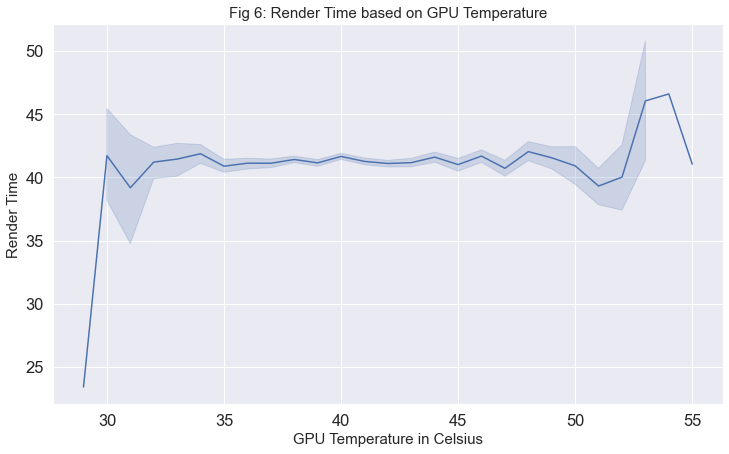

In [45]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.lineplot(data=merged_data.query("eventName == 'Render'"), x="gpuTempC", y="duration")
plt.xlabel('GPU Temperature in Celsius', fontsize = 15)
plt.ylabel('Render Time', fontsize = 15)
plt.title("Fig 6: Render Time based on GPU Temperature", fontsize = 15)
plt.show()

In [59]:
gpu['gpuSerial'] = gpu['gpuSerial'].astype(str)
gpu_powerdraw = gpu[['gpuSerial', 'powerDrawWatt']].groupby(['gpuSerial']).mean()
gpu_powerdraw.index.names = ['gpuSerial']
gpu_powerdraw.reset_index(inplace=True)

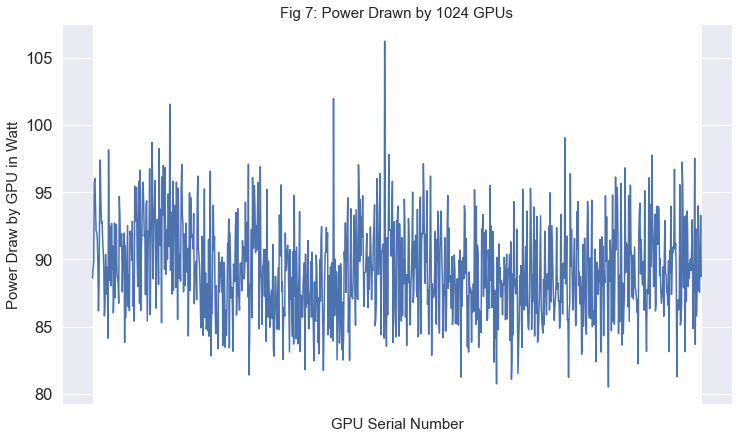

In [51]:
fig, ax = plt.subplots(figsize=(12, 7))
s = sns.lineplot(data = gpu_powerdraw, x="gpuSerial", y="powerDrawWatt")
plt.xlabel('GPU Serial Number', fontsize = 15)
plt.ylabel('Power Draw by GPU in Watt', fontsize = 15)
plt.title("Fig 7: Power Drawn by 1024 GPUs", fontsize = 15)
s.set(xticklabels=[])
plt.show()

In [60]:
gpu_powerdraw = gpu_powerdraw.sort_values(by = 'powerDrawWatt')
print("Low Performing GPUs")
gpu_powerdraw.head()

Low Performing GPUs


,gpuSerial,powerDrawWatt
867,325117171574,80.510313
679,325017017790,80.742673
704,325017018552,81.087075
800,325017049295,81.226755
619,324917052619,81.242179


In [54]:
print("High Performing GPUs")
gpu_powerdraw.tail()

High Performing GPUs


,gpuSerial,powerDrawWatt
100,323217056123,98.698678
794,325017049041,99.057575
130,323217056368,101.549633
405,323617021202,101.974324
491,323617042596,106.247462


In [40]:
from scipy.sparse import coo_matrix

In [140]:
heatmap_data = merged_data.drop_duplicates(
  subset = ['x', 'y'],
  keep = 'last').reset_index(drop = True)

heatmap_data = heatmap_data[heatmap_data['level'] == 12][['x', 'y', 'powerDrawWatt']]

In [141]:
heatmap_data = coo_matrix((heatmap_data.powerDrawWatt,(heatmap_data.y,heatmap_data.x))) 
heatmap_data = heatmap_data.toarray()

# heatmap_data = app_task_gpu[['x', 'y', 'powerDrawWatt']].pivot('y','x','powerDrawWatt').values

<AxesSubplot:>

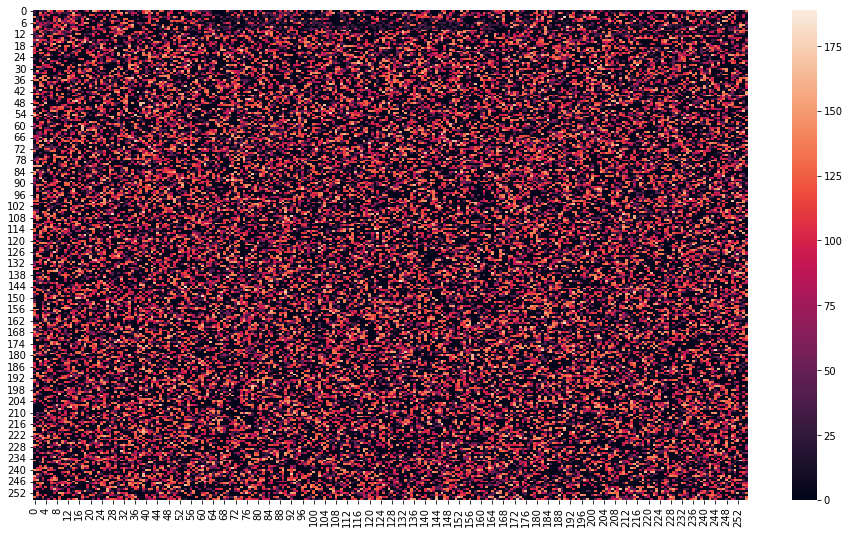

In [137]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(heatmap_data)

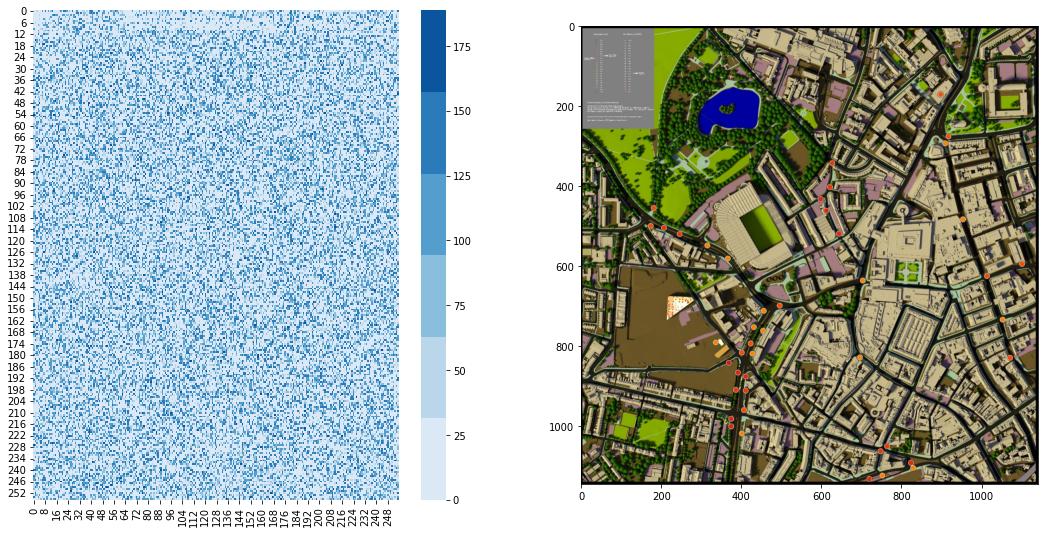

In [131]:
fig, ax = plt.subplots(figsize=(18, 9))
colormap = sns.color_palette("Blues")
rows, cols = 1, 2
plt.subplot(rows, cols, 1)
p = sns.heatmap(heatmap_data, cmap = colormap)
# p.invert_yaxis()
plt.subplot(rows, cols, 2)
img = plt.imread('../plots/map.png')
plt.imshow(img)
plt.show()

In [60]:
# start_stop['START'] = pd.to_datetime(merged_data['START'],format= '%H:%M:%S.%f' ).dt.time
# start_stop['STOP'] = pd.to_datetime(merged_data['STOP'],format= '%H:%M:%S.%f' ).dt.time
# sorted_df = merged_data.sort_values(by='START')
# start = merged_data['START']
# stop = merged_data['STOP']

In [41]:
start.head()

0    08:09:01.251000
1    07:50:28.866000
2    07:50:28.866000
3    08:26:28.850000
4    08:26:28.850000
Name: START, dtype: object

In [40]:
stop.head()

0    08:09:48.150000
1    07:51:11.528000
2    07:51:11.528000
3    08:27:13.182000
4    08:27:13.182000
Name: STOP, dtype: object

In [30]:
start = np.array(start[1:])
stop = np.array(stop[:-1])

In [34]:
start_stop = pd.DataFrame(start, stop)
start_stop.reset_index(inplace=True)
start_stop = start_stop.rename(columns = {'index':'START', 0 :'STOP'})
start_stop.head()

,START,STOP
0,08:09:48.150000,07:50:28.866000
1,07:51:11.528000,07:50:28.866000
2,07:51:11.528000,08:26:28.850000
3,08:27:13.182000,08:26:28.850000
4,08:27:13.182000,08:13:58.687000


In [61]:
# start_stop['STOP'] = pd.to_datetime(start_stop['STOP'],format= '%H:%M:%S.%f' ).dt.time


# hault_duration = start_stop.apply(lambda x: abs(dt.combine(date.today(), x['START']) - dt.combine(date.today(), x['STOP'])), axis=1)

# hault_duration.head()